0: 환경 준비 & Google Drive 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    recall_score
)

np.random.seed(21)
tf.random.set_seed(21)

Mounted at /content/drive


1: 데이터 로드 (assault + fight 통합)

In [2]:
BASE = "/content/drive/MyDrive/ProcessedDataset"

def load_class(cls):
    X = np.load(os.path.join(BASE, cls, "X.npy"))
    y = np.load(os.path.join(BASE, cls, "y.npy"))
    g = np.load(os.path.join(BASE, cls, "groups.npy"))
    return X, y, g

Xa, ya, ga = load_class("assault")
Xf, yf, gf = load_class("fight")

X = np.concatenate([Xa, Xf], axis=0)
y = np.concatenate([ya, yf], axis=0)
groups = np.concatenate([ga, gf], axis=0)

print("Total windows:", X.shape[0])
print("Feature shape:", X.shape[1:])


Total windows: 2160
Feature shape: (149, 5)


2: 시나리오 단위 Group Split

In [3]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train windows:", len(y_train))
print("Test windows :", len(y_test))

Train windows: 1728
Test windows : 432


3: Train / Test 분포 출력

In [4]:
print("\n[Train distribution]")
print("Positive:", int(y_train.sum()),
      "\nNegative:", len(y_train) - int(y_train.sum()),
      "\nRatio:", round(y_train.mean(), 3))

print("\n[Test distribution]")

print("Positive:", int(y_test.sum()),
      "\nNegative:", len(y_test) - int(y_test.sum()),
      "\nRatio:", round(y_test.mean(), 3))


[Train distribution]
Positive: 576 
Negative: 1152 
Ratio: 0.333

[Test distribution]
Positive: 144 
Negative: 288 
Ratio: 0.333


4: Class Weight 계산

In [5]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {0: weights[0], 1: weights[1]}
print("\nClass weights:", class_weight)


Class weights: {0: np.float64(0.75), 1: np.float64(1.5)}


5: LSTM 모델 정의

In [6]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 149, 64)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

6: 학습 (Early Stopping)

In [7]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4330 - loss: 0.6990 - val_accuracy: 0.4798 - val_loss: 0.7047
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5479 - loss: 0.6756 - val_accuracy: 0.5376 - val_loss: 0.6982
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5814 - loss: 0.6725 - val_accuracy: 0.5549 - val_loss: 0.7039
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6175 - loss: 0.6644 - val_accuracy: 0.5347 - val_loss: 0.7113
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6188 - loss: 0.6565 - val_accuracy: 0.5202 - val_loss: 0.7309
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6348 - loss: 0.6529 - val_accuracy: 0.5462 - val_loss: 0.7229
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6467 - loss: 0.6487 - val_accuracy: 0.5549 - val_loss: 0.7255


7: Best Epoch 출력

In [8]:
best_epoch = np.argmin(history.history["val_loss"]) + 1
print("\nBest epoch (Early Stopping):", best_epoch)


Best epoch (Early Stopping): 2


8: 테스트 데이터 예측

In [9]:
y_prob = model.predict(X_test).ravel()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


9: ROC-AUC / PR-AUC

In [10]:
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("\nROC-AUC:", round(roc_auc, 4))
print("PR-AUC :", round(pr_auc, 4))


ROC-AUC: 0.5515
PR-AUC : 0.3708


10: Threshold Sweep

In [11]:
print("\n[Threshold Sweep - Recall]")
for t in [0.5, 0.4, 0.3, 0.2]:
    recall = recall_score(y_test, (y_prob >= t).astype(int))
    print(f" Threshold {t:.1f} → Recall: {recall:.4f}")


[Threshold Sweep - Recall]
 Threshold 0.5 → Recall: 0.6389
 Threshold 0.4 → Recall: 0.9444
 Threshold 0.3 → Recall: 1.0000
 Threshold 0.2 → Recall: 1.0000


11: 최종 평가 (threshold = 0.4)

In [27]:
THRESHOLD = 0.4
y_pred = (y_prob >= THRESHOLD).astype(int)

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, digits=4))


Confusion Matrix
[[ 22 266]
 [  8 136]]

Classification Report
              precision    recall  f1-score   support

           0     0.7333    0.0764    0.1384       288
           1     0.3383    0.9444    0.4982       144

    accuracy                         0.3657       432
   macro avg     0.5358    0.5104    0.3183       432
weighted avg     0.6017    0.3657    0.2583       432



12: Threshold vs Recall 그래프

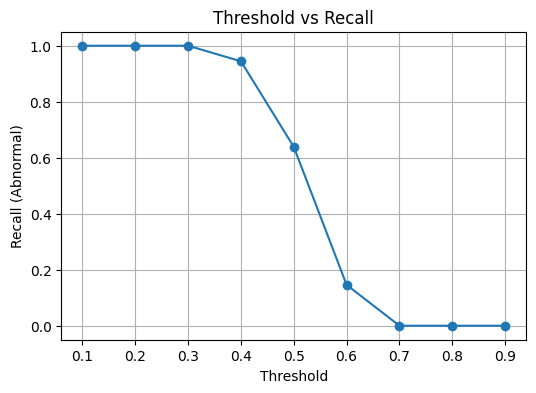

In [28]:
thresholds = np.linspace(0.1, 0.9, 9)
recalls = [recall_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Recall (Abnormal)")
plt.title("Threshold vs Recall")
plt.grid(True)
plt.show()

13: Confusion Matrix 히트맵 (threshold=0.4)

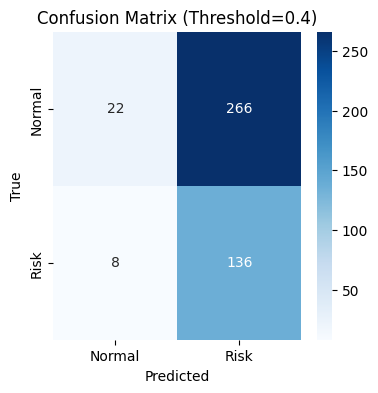

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Risk"],
            yticklabels=["Normal", "Risk"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Threshold=0.4)")
plt.show()

14: 학습 곡선 (Loss)

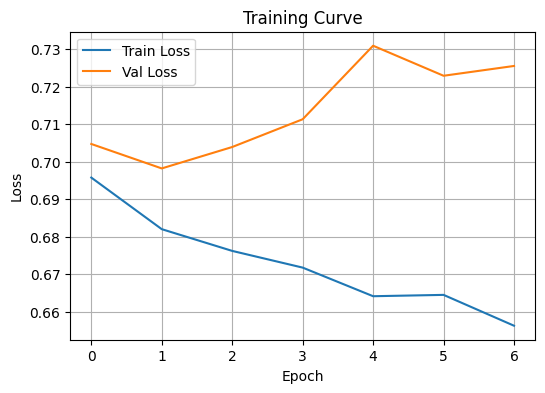

In [30]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Curve")
plt.grid(True)
plt.show()